# Preparation

### Import, constants and functions

In [ ]:
import numpy as np
from numpy.random import seed
#seed(12345)

import cv2
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from google.colab import drive
from google.colab.patches import cv2_imshow

In [ ]:
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [ ]:
def show_results(history):
  # Show training history (this cell is complete, nothing to implement here :-) )
  h = history.history
  epochs = range(len(h['loss']))

  plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
  plt.legend(['Train', 'Validation'])
  plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                            epochs, h['val_accuracy'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'])

  print('Train Acc     ', h['accuracy'][-1])
  print('Validation Acc', h['val_accuracy'][-1])

In [ ]:
def comparison(test_dataset, decoded_imgs, n):
  for ii in range(n):
      image_num = np.random.randint(0, len(test_dataset))

      plt.subplot(2,n,ii+1), plt.imshow(test_dataset[image_num, ...])
      plt.title("original")

      plt.subplot(2,n,ii+1+n), plt.imshow(decoded_imgs[image_num, ...])
      plt.title("reconstructed")    

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

### Data inspaction

In [ ]:
# Load data from the folder
with open('drive/MyDrive/Colab Notebooks/StreetCamera_Data_XX/train_dataset.npy', 'rb') as f:
    train_dataset = np.load(f)

with open('drive/MyDrive/Colab Notebooks/StreetCamera_Data_XX/test_dataset.npy', 'rb') as f:
    test_dataset = np.load(f)

hight = train_dataset.shape[1]
width = train_dataset.shape[2]

In [ ]:
print('Train set:   ', len(train_dataset), 'samples')
print('Test set:    ', len(test_dataset), 'samples')
print('Sample dims: ', train_dataset.shape)

Train set:    8621 samples
Test set:     4311 samples
Sample dims:  (8621, 128, 192, 3)


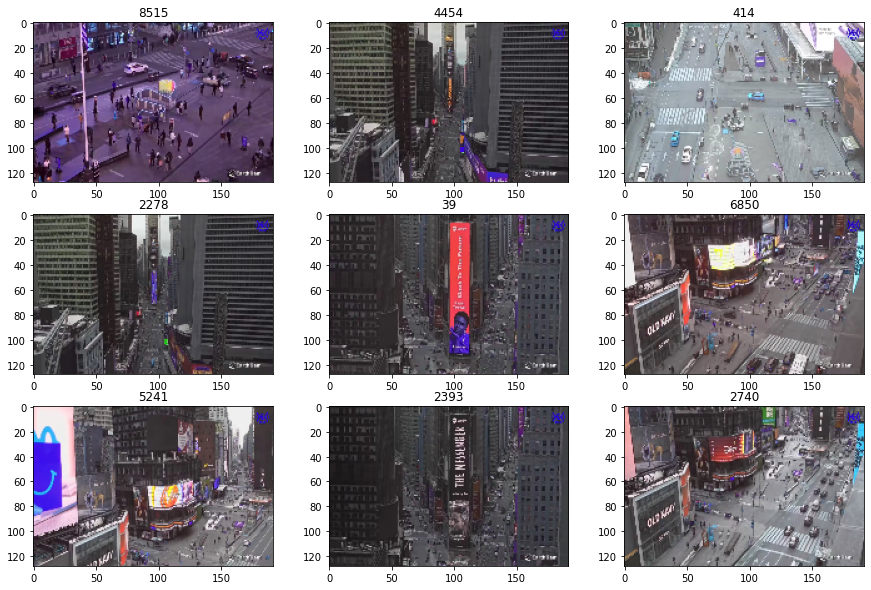

In [ ]:
# Show random samples
for ii in range(9):
    image_num = np.random.randint(0, len(train_dataset))
    plt.subplot(3,3,ii+1), plt.imshow(train_dataset[image_num, ...])
    plt.title(str(image_num))

#Building model

In [ ]:
# Normalization
train_dataset = train_dataset.astype('float32')/255
test_dataset = test_dataset.astype('float32')/255

## Model

###Creating

In [ ]:
latent_dim = 1000



#encoder============================================
inputs = layers.Input(shape=(hight, width, 3))

net = inputs

net = layers.Conv2D(64, (3, 3), strides=2, padding="same")(net)
net = layers.LeakyReLU(alpha=0.3)(net)
net = layers.BatchNormalization(axis=-1)(net)  

# loop over the number of filters
for f in (128, 256, 512):
  # apply a CONV => RELU => BN operation
  net = layers.Conv2D(f, (3, 3),strides=2, padding="same")(net)
  net = layers.LeakyReLU(alpha=0.3)(net)
  net = layers.BatchNormalization(axis=-1)(net)   
  
  

latentSize = K.int_shape(net)
net = layers.Flatten()(net)
latent = layers.Dense(latent_dim, activation='relu')(net)

encoder = Model(inputs, latent, name="encoder")




#decoder============================================
latentInputs = layers.Input(latent_dim)
net = layers.Dense(np.prod(latentSize[1:]))(latentInputs)
net = layers.Reshape((latentSize[1], latentSize[2], latentSize[3]))(net)

# loop over our number of filters again, but this time in
# reverse order
for f in (512, 256, 128, 64):
  # apply a CONV_TRANSPOSE => RELU => BN operation
  net = layers.Conv2DTranspose(f, (3, 3), strides=2, padding="same")(net)  
  net = layers.LeakyReLU(alpha=0.3)(net)
  net = layers.BatchNormalization(axis=-1)(net)
  #net = layers.UpSampling2D(2)(net)

net = layers.Conv2DTranspose(3, (3, 3), padding="same")(net)
outputs = layers.Activation("sigmoid")(net)

decoder = Model(latentInputs, outputs, name="decoder")



#autoencoder============================================
autoencoder = Model(inputs, decoder(encoder(inputs)),
            name="autoencoder")

###Summary

In [ ]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 192, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 96, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 96, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 64, 96, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 48, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 48, 128)       0         
                                                           

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_1 (Dense)             (None, 49152)             49201152  
                                                                 
 reshape (Reshape)           (None, 8, 12, 512)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 24, 512)      2359808   
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 24, 512)       0         
                                                                 
 batch_normalization_4 (Batc  (None, 16, 24, 512)      2048      
 hNormalization)                                           

In [ ]:
autoencoder.compile(optimizer='adam', loss=MeanSquaredError(), metrics=["accuracy"])

###Fit

In [ ]:
epochs = 20
batch_size = 16
history = autoencoder.fit(DataGenerator(train_dataset, train_dataset, batch_size),
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(DataGenerator(test_dataset, test_dataset, batch_size)))

Epoch 1/20
539/539 [==============================] - 1938s 4s/step - loss: 0.0278 - accuracy: 0.5763 - val_loss: 0.0198 - val_accuracy: 0.5590
Epoch 2/20
539/539 [==============================] - 1941s 4s/step - loss: 0.0129 - accuracy: 0.6369 - val_loss: 0.0191 - val_accuracy: 0.5553
Epoch 3/20
539/539 [==============================] - 1920s 4s/step - loss: 0.0093 - accuracy: 0.6694 - val_loss: 0.0092 - val_accuracy: 0.6429
Epoch 4/20
539/539 [==============================] - 1933s 4s/step - loss: 0.0080 - accuracy: 0.6841 - val_loss: 0.0087 - val_accuracy: 0.6997
Epoch 5/20
539/539 [==============================] - 1954s 4s/step - loss: 0.0073 - accuracy: 0.6915 - val_loss: 0.0081 - val_accuracy: 0.6991
Epoch 6/20
539/539 [==============================] - 1932s 4s/step - loss: 0.0070 - accuracy: 0.6954 - val_loss: 0.0081 - val_accuracy: 0.6931
Epoch 7/20
539/539 [==============================] - 1940s 4s/step - loss: 0.0066 - accuracy: 0.7000 - val_loss: 0.0084 - val_accuracy:

Train Acc      0.7647404670715332
Validation Acc 0.7528287172317505


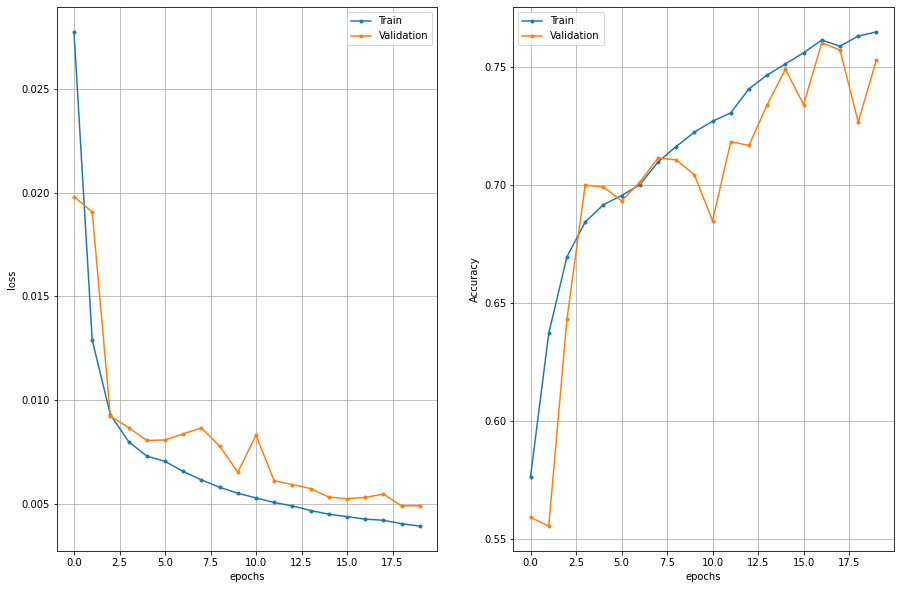

In [ ]:
show_results(history)

###Result inspaction

In [ ]:
encoded_imgs = encoder(test_dataset).numpy()
decoded_imgs = decoder(encoded_imgs).numpy()

with open('drive/MyDrive/Colab Notebooks/encoded_imgs.npy', 'wb') as f:
    np.save(f, encoded_imgs)

In [ ]:
print('Sample encoded: ', encoded_imgs.shape)
print('Sample decoded: ', decoded_imgs.shape)
print('comression: ', decoded_imgs.shape[1]*decoded_imgs.shape[2]*decoded_imgs.shape[3]/encoded_imgs.shape[1])

In [ ]:
# Show random comparison
comparison(test_dataset, decoded_imgs, 2)

In [ ]:
control_Img = cv2.imread('drive/MyDrive/Colab Notebooks/StreetCamera_Data_XX/monolisa.jpg')
control_Img = cv2.cvtColor(control_Img, cv2.COLOR_BGR2RGB)
control_Imgs = np.array([control_Img])

print('Sample dims: ', control_Imgs.shape)

control_Imgs = control_Imgs.astype('float32')/255

control_encoded_imgs = encoder(control_Imgs).numpy()
control_decoded_imgs = decoder(control_encoded_imgs).numpy()

plt.subplot(1,2,1), plt.imshow(control_Imgs[0])
plt.title("original")

plt.subplot(1,2,2), plt.imshow(control_decoded_imgs[0])
plt.title("reconstructed")   